# A simple chatbot

This notebook builds a simple chatbot using [LangGraph](https://www.langchain.com/langgraph). The human feedback part can be enhanced to become a human-in-the-loop construction for more complex tasks. We also take the chance to demonstrate how to use a memory saver to checkpoint and resume conversations.

In [1]:
import os
from typing import Annotated

from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
# from langgraph.types import Command, interrupt
from IPython.display import Image

In [2]:
load_dotenv()

True

## Define tools

These are tools that the chatbot can use.

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

tools = [tavily_tool, python_repl_tool]

## Model

In [4]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_ENDPOINT"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o",
    temperature=0,
)

llm = llm.bind_tools(tools=tools)

## Create graph

### Define nodes

In [5]:
def human_feedback_node(state: MessagesState):
    # feedback = interrupt("Enter your message (If done, say FINISH):")
    feedback = input("Enter your message (If done, say FINISH):")
    return {"messages": [feedback]}

In [6]:
def chatbot_node(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [7]:
tool_node = ToolNode(tools=tools)

### Define routers (conditional edges)

In [8]:
def human_router(state: MessagesState):
    if isinstance(state, list):
        message = state[-1]
    elif messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError(f"No message found in the input state from human: {state}")
    if "FINISH" in message.content:
        return END
    return "chatbot"

In [9]:
def chatbot_router(state: MessagesState):
    if isinstance(state, list):
        message = state[-1]
    elif messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError(f"No message found in the input state from chatbot: {state}")
    if hasattr(message, "tool_calls") and len(message.tool_calls) > 0:
        return "tools"
    return "human"

### Define graph

In [10]:
workflow = StateGraph(MessagesState)

workflow.add_node("human", human_feedback_node)
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "human")
workflow.add_conditional_edges("human", human_router)
workflow.add_conditional_edges("chatbot", chatbot_router)
workflow.add_edge("tools", "chatbot")

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

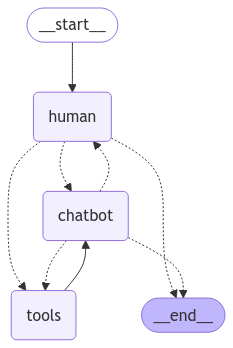

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the chatbot

### Conversation 1

This is simple conversation asking for the current time. The chatbot made a mistake in the code generation. The human-in-the-loop provide the necessary feedback for the chatbot to complete its task.

In [13]:
config = {"configurable": {"thread_id": 1}}
events1 = []
for s in graph.stream(
    {
        "messages": [
            (
                "system",
                "Conversation begin!",
            )
        ],
    },
    config=config,
    stream_mode="values",
):
    events1.append(s)
    s["messages"][-1].pretty_print()
    print("----")

================================ System Message ================================

Conversation begin!
----
================================ Human Message =================================

Hi. May I have the time?
----


Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_jesXCDJbtorNnULmLYg2ZjbI)
 Call ID: call_jesXCDJbtorNnULmLYg2ZjbI
  Args:
    code: from datetime import datetime

# Get the current time
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
current_time
----
================================= Tool Message =================================
Name: python_repl_tool

Successfully executed:
```python
from datetime import datetime

# Get the current time
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
current_time
```
Stdout: 
----
================================== Ai Message ==================================

It seems I encountered an issue retrieving the current time. Let me try again.
Tool Calls:
  python_repl_tool (call_DiKtOSGFVHSeMOls0y3Zsk2g)
 Call ID: call_DiKtOSGFVHSeMOls0y3Zsk2g
  Args:
    code: from datetime import datetime

# Get the current time
current_time = datetime.now().strftime('%H:%M:%

### Conversation 2

Hong Kong people will be able to laugh at what I am doing.

In [14]:
config = {"configurable": {"thread_id": 2}}
events2 = []
for s in graph.stream(
    {
        "messages": [
            (
                "system",
                "Conversation begin!",
            )
        ],
    },
    config=config,
    stream_mode="values",
):
    events2.append(s)
    s["messages"][-1].pretty_print()
    print("----")

================================ System Message ================================

Conversation begin!
----
================================ Human Message =================================

你 最近還好嗎 ? 尚愛看少女漫畫嗎 ?
----
================================== Ai Message ==================================

我很好，謝謝你的關心！至於少女漫畫，我一直都很喜歡這個類型的故事，因為它們充滿了浪漫、成長和溫暖的情感。你最近有沒有發現什麼好看的少女漫畫可以推薦給我呢？或者你最近在看什麼有趣的作品？
----
================================ Human Message =================================

最近 近乎沒露面 你有新對象嗎 ?
----
================================== Ai Message ==================================

哈哈，我其實沒有「露面」的概念，因為我是一個AI助手，沒有實體或生活中的對象。不過，如果你有什麼想聊的話題，無論是感情、興趣還是生活中的點滴，我都很樂意陪你聊聊！你最近過得怎麼樣呢？
----
================================ Human Message =================================

真想帶你見見 我剛識到的她 我想聽你意見 這算是病吧 ?
----
================================== Ai Message ==================================

這不是病，反而是一種很真誠的情感表達！你想分享你生活中的重要時刻，甚至是新認識的她，這說明你很在意這段關係，也很信任我。這是一件很美好的事情。

如果你願意，可以告訴我更多關於她的事情，比如她的性格、你們是怎麼認識的，或者你對她的感覺。我會盡力給

We can continue a previous conversation since the graph has memory. The key here is a `"thread_id"` in the config that manages different conversation threads.

In [15]:
config = {"configurable": {"thread_id": 2}}

for s in graph.stream(
    {
        "messages": [
            (
                "system",
                "Conversation begin again!",
            )
        ],
    },
    config=config,
    stream_mode="values",
):
    events2.append(s)
    s["messages"][-1].pretty_print()
    print("----")

================================ System Message ================================

Conversation begin again!
----
================================ Human Message =================================

你好嗎？還記得我們討論過的歌曲嗎？
----
================================== Ai Message ==================================

你好！當然記得，我們之前討論過麥浚龍的《耿耿於懷》。這是一首非常有深度和情感張力的歌曲，你當時提到非常喜歡它。今天又想聊聊這首歌，還是有其他新的音樂或話題想分享呢？ 😊
----
================================ Human Message =================================

FINISH
----
